In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [2]:
from MuDataFrame import *
import numpy as np
from scipy import stats

mdfo_calib = MuDataFrame("/Volumes/DAQ/PhotonTimeProp/dataFiles/calibration_new_set_up.csv")

mdf_calib = mdfo_calib.events_df
mdfo_calib.keep4by4Events()
mdfo_calib.og_df = mdf_calib.copy()
mdfo_calib.show()

,Unnamed: 0,index,event_num,event_time,deadtime,l1hit,l2hit,l3hit,l4hit,r1hit,...,z_angle,SmallCounter,speed,Run_Num,xx,yy,xx1,yy1,time_of_day,time
0,0,0,0,2021-05-03 12:40:15.812760,0,1.0,1.0,1.0,1.0,1.0,...,13.455446,NaN,0.342978,622,-5.445887,-22.562492,-6.807692,-22.684615,day,0
1,1,1,1,2021-05-03 12:40:16.502963,0,1.0,1.0,1.0,1.0,1.0,...,12.002813,NaN,0.703353,622,-11.762760,-21.506829,-11.538462,-21.784615,day,690203
2,2,2,2,2021-05-03 12:40:16.672924,0,1.0,1.0,1.0,1.0,1.0,...,14.672630,NaN,0.210716,622,35.347122,13.620282,36.676923,14.884615,day,860164
3,3,3,3,2021-05-03 12:40:16.892987,0,1.0,1.0,1.0,1.0,1.0,...,15.284964,NaN,0.259347,622,24.903617,25.826667,27.746154,29.153846,day,1080227
4,4,4,4,2021-05-03 12:40:17.563102,0,1.0,1.0,1.0,1.0,1.0,...,4.253100,NaN,11.038012,622,6.978340,14.482143,7.676923,15.230769,day,1750342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999992,2999992,99992,2999992,2021-05-20 13:18:29.305435,0,1.0,1.0,1.0,1.0,1.0,...,4.471381,NaN,2.208244,656,-24.827750,-14.125268,-25.330769,-14.146154,day,1077344492675
2999993,2999993,99993,2999993,2021-05-20 13:18:29.875548,0,1.0,1.0,1.0,1.0,1.0,...,15.702291,NaN,0.346495,656,13.468468,-38.856563,13.800000,-37.423077,day,1077345062788
2999994,2999994,99994,2999994,2021-05-20 13:18:30.125522,0,1.0,1.0,1.0,1.0,1.0,...,13.684312,NaN,0.276322,656,28.348837,-29.674472,28.130769,-29.230769,day,1077345312762
2999996,2999996,99996,2999996,2021-05-20 13:18:30.965416,0,1.0,1.0,1.0,1.0,1.0,...,6.035804,NaN,0.442759,656,12.892377,-12.244589,13.269231,-13.276923,day,1077346152656


# Getting peak coords

In [3]:
def getIntersections(t, curve1, curve2, doPlot=True):
    intersections = []
    xvals = []
    prev_dif = 0
    t0, prev_c1, prev_c2 = None, None, None
    for t1, c1, c2 in zip(t, curve1, curve2):
        new_dif = c2 - c1
        if np.abs(new_dif) < 1e-12:  # found an exact zero, this is very unprobable
            intersections.append((t1, c1))
        elif new_dif * prev_dif < 0:
            denom = prev_dif - new_dif
            xvals.append((-new_dif * t0 + prev_dif * t1) / denom)
            intersections.append(((-new_dif * t0 + prev_dif * t1) / denom,
                                  (c1 * prev_c2 - c2 * prev_c1) / denom))
        t0, prev_c1, prev_c2, prev_dif = t1, c1, c2, new_dif

    if doPlot:
        fig, ax = plt.subplots()
        ax.plot(t, curve1, 'b-')
        ax.plot(t, curve2, 'r-')
        ax.plot(*zip(*intersections), 'kx', ms=5)
        plt.show()
    
    diffs = np.diff(xvals)
    return xvals

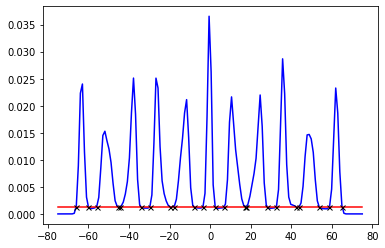

In [4]:
from scipy.stats import gaussian_kde
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
data = mdfo_calib.get("diffL1")
bandwidth = 0.02
density1 = gaussian_kde(data, bw_method=bandwidth)
xs = np.linspace(-75,75,150)
t = xs
curve1 = density1(xs)
curve2 = len(curve1) * [0.00135]
vals = getIntersections(t, curve1, curve2)
L1cuts = np.reshape(vals,[11,2])
L1cuts = np.flip(L1cuts,0)

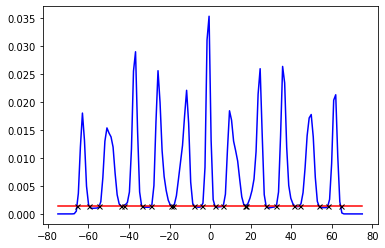

In [5]:
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
data2 = mdfo_calib.get("diffL2")
bandwidth = 0.02
density2 = gaussian_kde(data2, bw_method=bandwidth)
xs = np.linspace(-75,75,150)
t = xs
curve1 = density2(xs)
curve2 = len(curve1) * [0.0015]
vals2 = getIntersections(t, curve1, curve2)
L2cuts = np.reshape(vals2,[11,2])
L2cuts = np.flip(L2cuts,0)

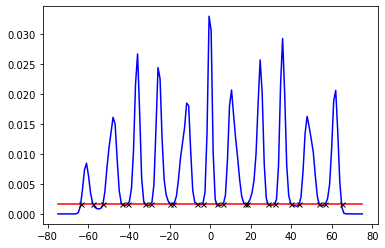

In [6]:
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
data3 = mdfo_calib.get("diffL3")
bandwidth = 0.025
density3 = gaussian_kde(data3, bw_method=bandwidth)
xs = np.linspace(-75,75,150)
t = xs
curve1 = density3(xs)
curve2 = len(curve1) * [0.0017]
vals3 = getIntersections(t, curve1, curve2)
L3cuts = np.reshape(vals3,[11,2])
L3cuts = np.flip(L3cuts,0)

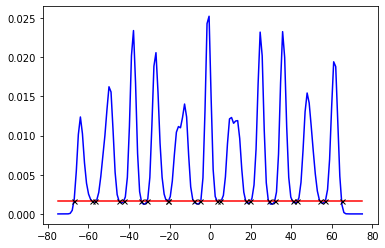

In [7]:
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
data4 = mdfo_calib.get("diffL4")
bandwidth = 0.03
density4 = gaussian_kde(data4, bw_method=bandwidth)
xs = np.linspace(-75,75,150)
t = xs
curve1 = density4(xs)
curve2 = len(curve1) * [0.0016]
vals4 = getIntersections(t, curve1, curve2)
L4cuts = np.reshape(vals4,[11,2])
L4cuts = np.flip(L4cuts,0)

# Predictions
### TODO: add option for function type to getYPreds

In [8]:
#Peak endpoints for Ch6 in L1/L3
L1cuts[5], L3cuts[5]

(array([-3.49018966,  2.49572508]), array([-3.71710597,  3.22040137]))

In [9]:
def getChData(data, ch, topPeaks, botPeaks):
    i = 0
    TDCS_List = []

    topDiff = "diffL" + str(ch)
    botDiff = "diffL" + str(ch+1)
    final = "L" + str(ch)
    
    #for peak in topPeaks:
        # isolate the peaks
            #data.reload()
            #data.keep4by4Events()
            #data.keepEvents("z_angle",9.391,"<=")
            #data.keepEvents(topDiff, peak[1],"<=")
            #data.keepEvents(topDiff, peak[0],">=")
        # generate the L4 peaks
            #L4 = getIndividualPeaks(mdfo_calib, "diffL4",thresh=0.002,bw=0.03,doPlot=False)
    for each_peak in botPeaks:
        #print(i)
        #i+=1
        data.reload()
        data.keep4by4Events()
        #data.keepEvents("z_angle",9.391,"<=")
        data.keepEvents(topDiff,topPeaks[1],"<=")
        data.keepEvents(topDiff,topPeaks[0],">=")

        data.keepEvents(botDiff,each_peak[1],"<=")
        data.keepEvents(botDiff,each_peak[0],">=")
        # store the tdcs
        TDCS_List.append(data.get(final))
    return TDCS_List

In [10]:
#Get TDC dist only from L1/L3 Ch6 and onto each channel in L2/L4 (0-10)
TDCS_L1Ch6_L2 = getChData(mdfo_calib, 1, L1cuts[5], L2cuts)
TDCS_L3Ch6_L4 = getChData(mdfo_calib, 3, L3cuts[5], L4cuts)

Shanto work

In [13]:
len(TDCS_L1Ch6_L2[1])

17547

In [14]:
yrange = [5*i-2.5 for i in range(1,12)]

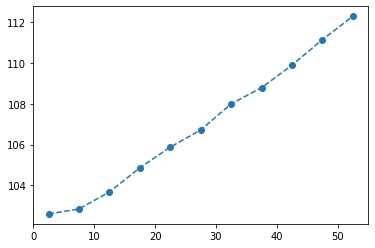

In [15]:
plt.plot(yrange,L1Ch6_L2means,'--o')
plt.show()

Shanto work end

In [11]:
#Get TDC means of L1/L3 Ch6 onto each channel in L2/L4
L1Ch6_L2means = []
L1Ch6_L2stds = []

L3Ch6_L4means = []
L3Ch6_L4stds = []


for i, j in zip(TDCS_L1Ch6_L2, TDCS_L3Ch6_L4):
    temp1 = stats.describe(i)
    temp3 = stats.describe(j)
    L1Ch6_L2means.append(round(temp1[2],3))
    L1Ch6_L2stds.append(round(np.sqrt(temp1[3]),3))
    L3Ch6_L4means.append(round(temp3[2],3))
    L3Ch6_L4stds.append(round(np.sqrt(temp3[3]),3))

In [12]:
"TDC means of Layer 1 Ch6  onto Layer 2", L1Ch6_L2means, "TDC means of Layer 3 Ch6 onto Layer 4", L3Ch6_L4means

('TDC means of Layer 1 Ch6  onto Layer 2',
 [102.603,
  102.844,
  103.681,
  104.864,
  105.881,
  106.724,
  108.0,
  108.794,
  109.904,
  111.153,
  112.298],
 'TDC means of Layer 3 Ch6 onto Layer 4',
 [93.853,
  94.603,
  95.286,
  95.94,
  96.979,
  97.432,
  97.952,
  98.143,
  98.391,
  99.226,
  99.759])

### Get mean TDC for L1/L3 for each channel to represent channel for prediction

In [16]:
#get TDC means for each channel in L1/L3 --> independent variable for regression
def getSingleLayerData(data, layer, peaks):
    diff = "diffL" + str(layer)
    final = "L" + str(layer)
    TDCS_List = []
    for each_peak in peaks:
        data.reload()
        data.keep4by4Events()
        #data.keepEvents("z_angle",9.391,"<=")
        data.keepEvents(diff, each_peak[1],"<=")
        data.keepEvents(diff, each_peak[0],">=")
        # store the tdcs
        TDCS_List.append(data.get(diff))
    return TDCS_List

In [17]:
L1_TDCraw = getSingleLayerData(mdfo_calib, 1, L1cuts)
L3_TDCraw = getSingleLayerData(mdfo_calib, 3, L3cuts)

In [18]:
L1_means = []
L3_means = []

for i, j in zip(L1_TDCraw, L3_TDCraw):
    temp1 = stats.describe(i)
    temp3 = stats.describe(j)
    L1_means.append(round(temp1[2],3))
    L3_means.append(round(temp3[2],3))

In [19]:
L3_means, L3Ch6_L4means

([61.328,
  48.644,
  35.723,
  24.234,
  11.289,
  -0.11,
  -12.136,
  -24.983,
  -36.024,
  -48.144,
  -60.908],
 [93.853,
  94.603,
  95.286,
  95.94,
  96.979,
  97.432,
  97.952,
  98.143,
  98.391,
  99.226,
  99.759])

In [20]:
L1_means = np.asarray(L1_means)
L1_means = L1_means.reshape((11,1))

L3_means = np.asarray(L3_means)
L3_means = L3_means.reshape((11,1))

In [21]:
#get predictions for a discrete x (cuts made on each channel) and corresponding mean TDC values
def getYPreds(Xmeans, Ymeans):
    #ch = 0
    Xmeans = np.array(Xmeans).reshape(11,1)
    yPredList = []
    eqn_vars = [] #[coefficient, intercept]
    x = np.arange(11)
    x=x.reshape((11,1))
    reg = linear_model.LinearRegression()
    reg.fit(Xmeans, Ymeans)
    yPredList.append(reg.predict(x))
    #for j in range(11):
        #res.append(abs(meansList[j]-yPredList[i][j]))
        #ch += 11
    return yPredList, reg

In [22]:
L1_PredSample, L1Ch6_reg = getYPreds(yrange, L1Ch6_L2means)
L3_PredSample, L3Ch6_reg = getYPreds(yrange, L3Ch6_L4means)

In [23]:
L1_PredSample

[array([101.45895909, 101.65961182, 101.86026455, 102.06091727,
        102.26157   , 102.46222273, 102.66287545, 102.86352818,
        103.06418091, 103.26483364, 103.46548636])]

In [24]:
# y = L1_eqn[0] * x + L1_eqn[1]
# y = L1Ch6_coef_ * x + L1Ch6_fit.intercept_
"Layer 1 parameters", L1Ch6_reg.coef_, L1Ch6_reg.intercept_, "Layer 3 parameters", L3Ch6_reg.coef_, L3Ch6_reg.intercept_,

('Layer 1 parameters',
 array([0.20065273]),
 101.4589590909091,
 'Layer 3 parameters',
 array([0.11402909]),
 93.91547272727271)

In [25]:
Y2PredList = []

mdfo_calib.reload()
mdfo_calib.keep4by4Events()

for i in mdfo_calib.events_df.L1.values:
    Y2PredList.append((L1Ch6_reg.intercept_ - i)/L1Ch6_reg.coef_)

In [26]:
mdfo_calib.events_df.diffL2.values[10]

10.0

In [27]:
Y2PredList[10]*(130/55)

array([-277.30727156])

In [ ]:
diffList = (mdfo_calib.events_df.diffL2.values - np.array(Y2PredList))/mdfo_calib.events_df.diffL2.values

In [ ]:
plt.hist(diffList)

In [43]:
#plt.hist(mdfo_calib.events_df.diffL2.values,bins=11,range=(-90,90))
#plt.show()
min(mdfo_calib.events_df.diffL2.values)

-865.0

In [41]:
min(Y2PredList)
#plt.hist(Y2PredList)
#plt.show()

array([-4527.92769507])

In [ ]:
#len(mdfo_calib.events_df.L1.values)
mdfo_calib.events_df.L1.values[0]

# scratchwork

In [ ]:
"""
fig = plt.figure()
x = np.arange(11)
y = L3mean[0:11]
yerr3 = L3std[0:11]

axes = plt.gca()
axes.set_xlim([0,10.25])
axes.set_ylim([125,150])

plt.title("Distribution of L3 Ch1 onto L4")
plt.plot(x,y3, label = "actual")
#plt.plot(x, y_pred3, label = "pred")
plt.errorbar(x, y_pred3, xerr=0, yerr=res3)
plt.legend()
plt.show()
"""

In [ ]:
"""
fig = plt.figure()
x = np.arange(11)
y = L1mean[0:11]
yerr = L1std[0:11]

axes = plt.gca()
axes.set_xlim([0,10.25])
axes.set_ylim([100,200])

plt.title("Distribution of L1 Ch1 onto L2")
plt.errorbar(x, y, xerr=0, yerr=yerr)
plt.show()


fig = plt.figure()
y3 = L3mean[0:11]
yerr3 = L3std[0:11]

axes = plt.gca()
axes.set_xlim([0,10.25])
axes.set_ylim([100,200])

plt.title("Distribution of L3 Ch1 onto L4")
plt.errorbar(x, y3, xerr=0, yerr=yerr3)
plt.show()
"""

In [ ]:
#pp = PdfPages('multipage.pdf')
#pp.savefig()
#pp.close()
'''
bins = np.arange(0,200)
s = stats.describe(TDCS_L1[0])
plt.hist(TDCS_L1[0], bins=bins)
graphStats = "Mean = {}   Std = {}".format(round(s[2],2), round(np.sqrt(s[3]),2))
plt.title(graphStats)
plt.suptitle("Layer 1 Ch1: Layer 2 Ch 1")
plt.show()


t = stats.describe(TDCS_L3[0])
plt.hist(TDCS_L1[0], bins= bins)
graphStats = "Mean = {}   Std = {}".format(round(t[2],2), round(np.sqrt(t[3]),2))
plt.title(graphStats)
plt.suptitle("Layer 3 Ch1: Layer 4 Ch 1")
plt.show()
'''

In [ ]:
"""
res = []
for i in range(11):
    res.append(abs(y[i]-y_pred[i]))

fig = plt.figure()
x = np.arange(11)
y = L1mean[0:11]
yerr = L1std[0:11]

axes = plt.gca()
axes.set_xlim([0,10.25])
axes.set_ylim([125,150])

plt.title("Distribution of L1 Ch1 onto L2")
plt.plot(x,y, label = "actual")
#plt.plot(x, y_pred3, label = "pred")
plt.errorbar(x, y_pred, xerr=0, yerr=res)
plt.legend()
plt.show()
"""

In [ ]:
"""
resA1 =  [abs(ele) for ele in res]
resA3 =  [abs(ele) for ele in res3]

plt.title("Residule of L1 and L3")
plt.plot(x,resA1, label = "L1")
plt.plot(x, resA3, label = "L3")
plt.legend()
plt.show()
"""

In [ ]:
"""
for i in range(11):
    plt.hist(L1_yPredList[i], bins= bins)
#graphStats = "Mean = {}   Std = {}".format(round(t[2],2), round(np.sqrt(t[3]),2))
plt.title("L2 Prediction")
#plt.suptitle("Layer 3 Ch1: Layer 4 Ch 1")
plt.show()
"""